Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3788 images belonging to 2 classes.
Found 945 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.
Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 592ms/step - accuracy: 0.8565 - loss: 0.3123 - val_accuracy: 0.9677 - val_loss: 0.0906
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0734 - val_accuracy: 0.8824 - val_loss: 0.2380
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 577ms/step - accuracy: 0.9711 - loss: 0.0779 - val_accuracy: 0.9741 - val_loss: 0.0782
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.2604 - val_accuracy: 0.9412 - val_loss: 0.1223
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 71s 576ms/step - accuracy: 0.9802 - loss: 0.0592 - val_accuracy: 0.9763 - val_loss: 0.0745
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0549 - val_accur

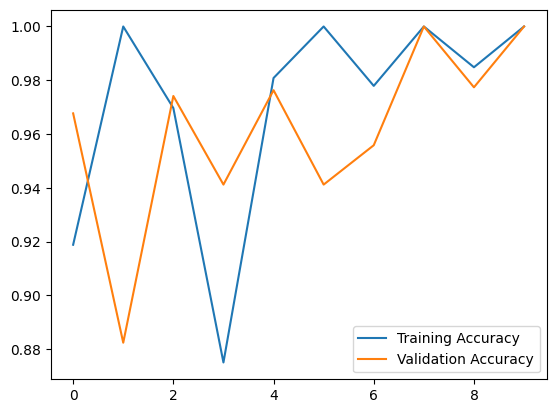

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.9842 - loss: 0.0479
Test Accuracy: 0.98
Class mapping: {'chihuahua': 0, 'muffin': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
Image: img_0_228.jpg -> Prediction: Muffin


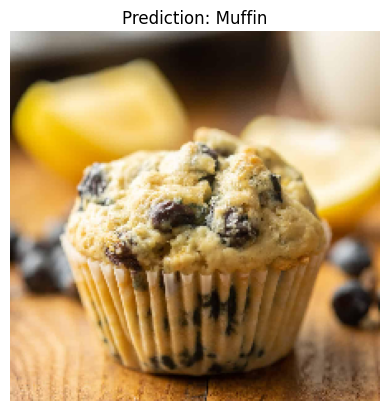

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: img_0_930.jpg -> Prediction: Chihuahua


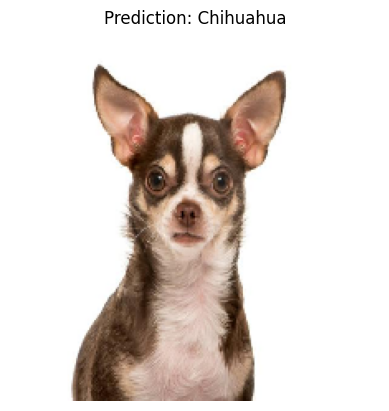

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: img_0_431.jpg -> Prediction: Muffin


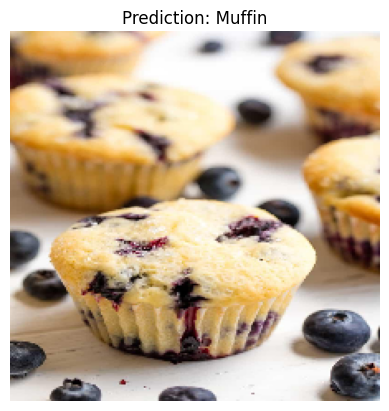

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: img_0_1172.jpg -> Prediction: Chihuahua


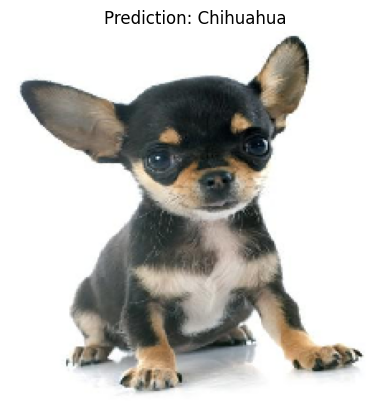

In [4]:
# Run on Colab
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Set data paths
base_dir = '/content/drive/My Drive/archive'  # Path to archive folder
train_dir = os.path.join(base_dir, 'train')  # Path to training data
test_dir = os.path.join(base_dir, 'test')  # Path to test data

# Path to the folder for testing additional images
test1_dir = '/content/drive/My Drive/test1'  # Path to test1 folder containing test images

# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% for training / 20% for validation
    horizontal_flip=True,
    zoom_range=0.2,
)

# Prepare training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Prepare validation data generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Do not shuffle test data
)

# Build the VGGNet model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained weights

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust the number of epochs as needed
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Visualize training results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Display class mapping
print("Class mapping:", train_generator.class_indices)

# Classify images in a folder
def classify_images_in_folder(folder_path):
    # List all image files in the specified folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))]
    for image_path in image_files:
        img = load_img(image_path, target_size=(224, 224))  # Load and resize the image
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        prediction = model.predict(img_array)  # Predict the class

        # Interpret the output
        if prediction[0][0] > 0.5:
            class_name = 'Muffin'  # Classify as Muffin if probability > 0.5
        else:
            class_name = 'Chihuahua'  # Classify as Chihuahua if probability <= 0.5

        # Display the result
        print(f"Image: {os.path.basename(image_path)} -> Prediction: {class_name}")
        plt.imshow(img)
        plt.title(f"Prediction: {class_name}")
        plt.axis('off')
        plt.show()

# Run classification on images in test1 folder
classify_images_in_folder(test1_dir)

